In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import SphericalVoronoi
from numba import njit
from scipy.spatial.transform import Rotation as R


import cartopy.crs as ccrs
from tqdm import tqdm





In [2]:
class RandomOnSphere:
    def __init__(self,seed=0):
        self.rngState=np.random.RandomState(seed)
    def generate(self,N):
        normalSamples=np.resize(self.rngState.normal(size=(N,3)),(N,3))
        norm=np.sum(normalSamples**2,axis=1)**.5
        for i in range(3):
            normalSamples[:,i]/=norm
        return normalSamples
    

    
class Projection:
        def __init__(self):
            self.ex=np.array([1,0,0])
            self.ey=np.array([0,1,0])
            self.ez=np.array([0,0,1])
        def toLatLong(self,r,units="rad"):
            lat,long=toLatLong(r,self.ex,self.ey,self.ez)
            if(units=="rad"):
                return lat,long
            elif(units=="deg"):
                return (lat-np.pi/2)/np.pi*180,long/np.pi*180
            
class Mercator(Projection):
        def __init__(self):
            Projection.__init__(self)
        def toXY(self,r):
            lat,long=self.toLatLong(r)
            return long,np.log(np.tan(lat/2))
        
def slerp(v0, v1, t_array):
    """Spherical linear interpolation."""
    dot = np.sum(v0 * v1)
    if dot < 0.0:
        v1 = -v1
        dot = -dot    
    DOT_THRESHOLD = 0.9995
    if dot > DOT_THRESHOLD:
        result = v0[np.newaxis,:] + t_array[:,np.newaxis] * (v1 - v0)[np.newaxis,:]
        return (result.T / np.linalg.norm(result, axis=1)).T    
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)
    theta = theta_0 * t_array
    sin_theta = np.sin(theta)    
    s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
    s1 = sin_theta / sin_theta_0
    return (s0[:,np.newaxis] * v0[np.newaxis,:]) + (s1[:,np.newaxis] * v1[np.newaxis,:])

@njit
def distanceMatrix(r):
    n=r.shape[0]
    M=np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            M[i,j]=np.arccos(np.dot(r[i],r[j]))
    return M+M.transpose()

def energy(r):
    M=distanceMatrix(r)
    return np.sum(1/M[np.abs(M)>1e-6])    

def take_step(r):
    randomOnSphere=RandomOnSphere().generate(r.shape[0])
    p=2*1e-2*500/r.shape[0]
    rnd=np.random.uniform(size=r.shape[0])
    randomNorm=np.random.normal(0,scale=take_step.stepsize,size=r.shape[0])*np.piecewise(rnd,[rnd<p],[1,0])
    for i in range(3):
        randomOnSphere[:,i]*=randomNorm
    newPoints=R.from_rotvec(randomOnSphere).apply(r)
    return newPoints
take_step.stepsize=0.01

In [78]:
N=200
phi=1.324717957244746025960908854
u=np.modf(np.arange(1,N+1)/phi)[0]
v=np.modf(np.arange(1,N+1)/phi**2)[0]
l=np.arccos(2*u-1)+np.pi/2
p=2*np.pi*v
points=np.array([np.cos(l)*np.cos(p),np.cos(l)*np.sin(p),np.sin(l)]).transpose()

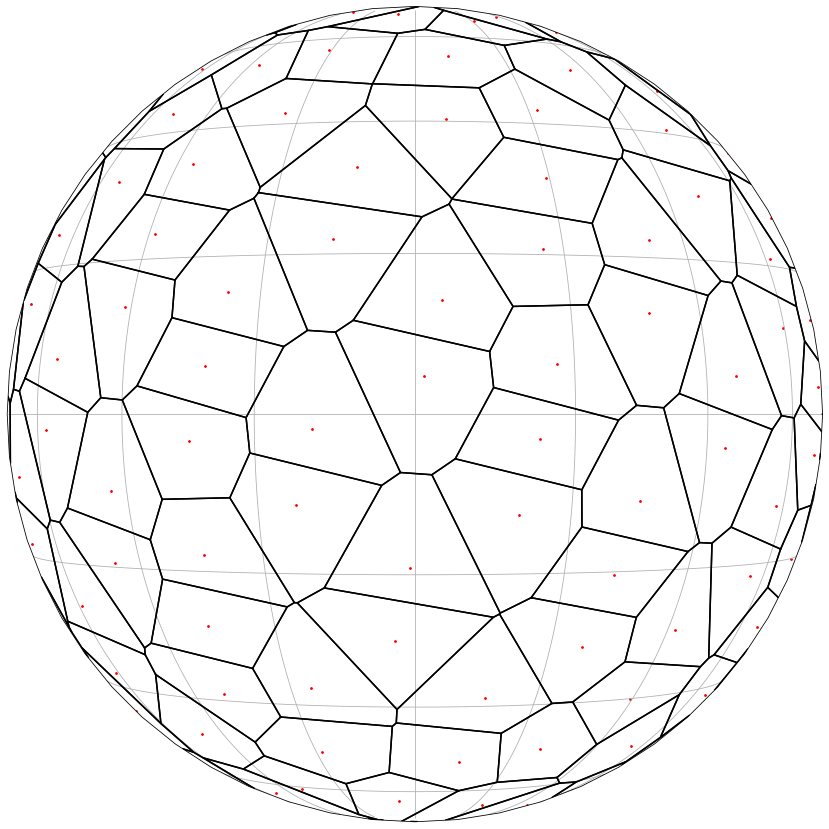

In [79]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_longitude=0))

sv=SphericalVoronoi(points)
sv.sort_vertices_of_regions()

lat,long=Projection().toLatLong(points,"deg")
ax.scatter(long,lat,s=3,color="red",transform=ccrs.PlateCarree())
ax.gridlines()
ax.set_global()

for i in range(len(sv.regions)):
    vertices=sv.vertices[np.append(sv.regions[i],sv.regions[i][0])]
    lat,long=Projection().toLatLong(vertices,"deg")
    ax.plot(long,lat,"k-",transform=ccrs.Geodetic())
plt.show()

In [80]:
for i in tqdm(range(50)):
    sv=SphericalVoronoi(points)
    for i in range(len(sv.points)):
        points[i]=np.mean(sv.vertices[sv.regions[i]],axis=0)
        points[i]/=np.linalg.norm(points[i])

100%|██████████| 50/50 [00:00<00:00, 116.73it/s]


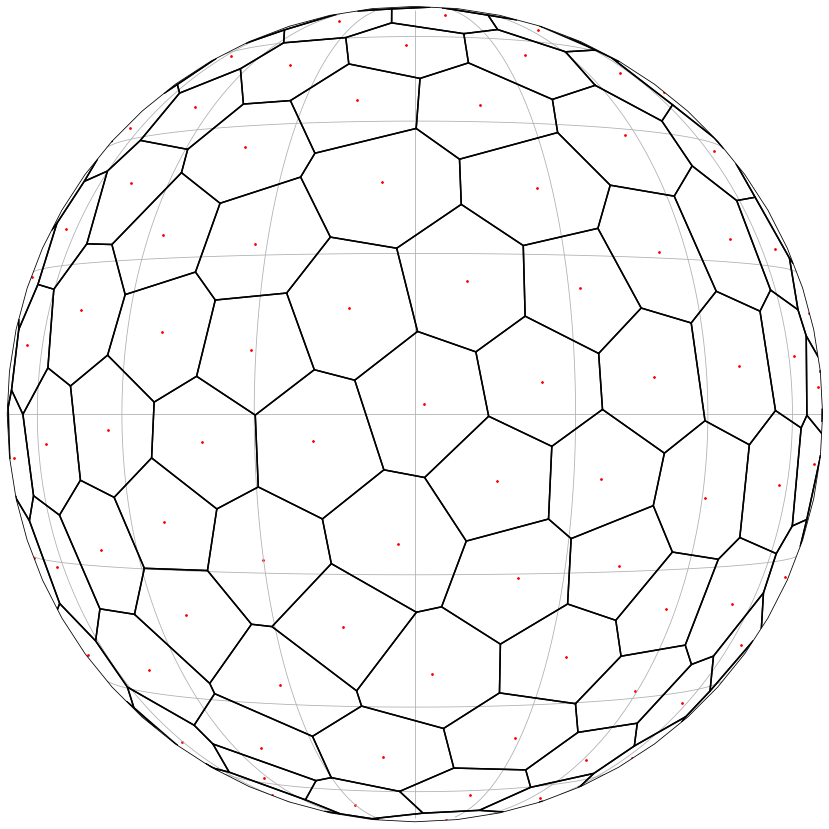

In [83]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_longitude=0))

sv=SphericalVoronoi(points)
sv.sort_vertices_of_regions()

lat,long=Projection().toLatLong(points,"deg")
ax.scatter(long,lat,s=3,color="red",transform=ccrs.PlateCarree())
ax.gridlines()
ax.set_global()

for i in range(len(sv.regions)):
    vertices=sv.vertices[np.append(sv.regions[i],sv.regions[i][0])]
    lat,long=Projection().toLatLong(vertices,"deg")
    ax.plot(long,lat,"k-",transform=ccrs.Geodetic())
plt.show()

In [ ]:
def geometryProperties(sv):
    sides=np.zeros(len(sv.regions))
    for i in range(len(sv.regions)):
        sides[i]=len(sv.regions[i])
    return sides